# 1. GCN on Cora — Enc / Gt / Dec / L

- **Encoder (Enc)**: Two-layer Graph Convolutional Network (GCN) that transforms node features into hidden embeddings using neighborhood information; uses ReLU, dropout, and L2 weight decay on the first layer.
- **Graph transformation (Gt)**: Adjacency matrix `A` is preprocessed with self-loops and symmetric normalization (`gcn_filter`) to enable normalized message passing during convolution.
- **Decoder (Dec)**: Final GCN layer projects hidden embeddings to class logits, followed by softmax to output per-node class probabilities.
- **Loss (L)**: Masked categorical cross-entropy computed only on train nodes, with early stopping on validation loss to prevent overfitting; same loss, epochs, batch size, and masks as the MLP baseline for fairness.


## 2. Load and preprocess data 

In [1]:
import os
import numpy as np
import scipy.sparse as sp
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

from spektral.layers import GCNConv
from spektral.utils import convolution
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Load arrays from ../data/ (robust to cwd)
from pathlib import Path

cwd = Path.cwd().resolve()
repo_root = cwd if (cwd / "data").exists() else cwd.parent
DATA_DIR = repo_root / "data"

X = np.load(DATA_DIR / "X.npy").astype(np.float32)
y = np.load(DATA_DIR / "y.npy").astype(np.float32)
A = sp.load_npz(DATA_DIR / "A.npz")
train_mask = np.load(DATA_DIR / "train_mask.npy")
val_mask = np.load(DATA_DIR / "val_mask.npy")
test_mask = np.load(DATA_DIR / "test_mask.npy")

# Convert to tensors
X = tf.constant(X, dtype=tf.float32)
y = tf.constant(y, dtype=tf.float32)

# Preprocess adjacency: add self-loops + symmetric normalization
A_processed = convolution.gcn_filter(A).tocoo()
A_tensor = tf.sparse.SparseTensor(
    np.array([A_processed.row, A_processed.col]).T,
    A_processed.data.astype(np.float32),
    A_processed.shape,
)
A_tensor = tf.sparse.reorder(A_tensor)

# Ensure masks are float tensors for sample weights
train_mask = tf.constant(train_mask.astype(np.float32))
val_mask = tf.constant(val_mask.astype(np.float32))
test_mask = tf.constant(test_mask.astype(np.float32))

print("✅ Loaded data from disk successfully\n")
print(f"X shape:        {X.shape}")
print(f"y shape:        {y.shape}")
print(f"A shape:        {A.shape} (sparse)")
print(f"Train samples:  {tf.reduce_sum(train_mask).numpy()}")
print(f"Val samples:    {tf.reduce_sum(val_mask).numpy()}")
print(f"Test samples:   {tf.reduce_sum(test_mask).numpy()}")


2025-12-18 14:37:41.541087: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-18 14:37:41.603154: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-18 14:37:43.008899: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


✅ Loaded data from disk successfully

X shape:        (2708, 1433)
y shape:        (2708, 7)
A shape:        (2708, 2708) (sparse)
Train samples:  140.0
Val samples:    500.0
Test samples:   1000.0


2025-12-18 14:37:44.649654: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


## 3. Prepare masks and shapes

In [2]:
num_nodes, num_features = X.shape
num_classes = y.shape[1]

print("Data splits:")
print(f"  Train: {tf.reduce_sum(train_mask).numpy()} nodes")
print(f"  Val:   {tf.reduce_sum(val_mask).numpy()} nodes")
print(f"  Test:  {tf.reduce_sum(test_mask).numpy()} nodes")
print(f"  Num features: {num_features}")
print(f"  Num classes:  {num_classes}")


Data splits:
  Train: 140.0 nodes
  Val:   500.0 nodes
  Test:  1000.0 nodes
  Num features: 1433
  Num classes:  7


## 4. Build the GCN model 
- uses two GCN layers with ReLU + dropout (first layer has L2 weight decay), followed by a softmax output. Loss: categorical cross-entropy (masked).

In [3]:
class NoMaskGCN(GCNConv):
    def call(self, inputs, mask=None):
        if isinstance(mask, (list, tuple)) and all(m is None for m in mask):
            mask = None
        return super().call(inputs, mask=mask)


dropout_rate = 0.5
l2_reg = 5e-4
learning_rate = 0.01

X_in = layers.Input(shape=(num_features,), name="X_in")
A_in = layers.Input((None,), sparse=True, name="A_in")

x = layers.Dropout(dropout_rate)(X_in)
x = NoMaskGCN(16, activation="relu", kernel_regularizer=keras.regularizers.l2(l2_reg))([x, A_in])
x = layers.Dropout(dropout_rate)(x)
outputs = NoMaskGCN(num_classes, activation="softmax")([x, A_in])

model = keras.Model(inputs=[X_in, A_in], outputs=outputs)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ X_in (InputLayer)   │ (None, 1433)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1433)      │          0 │ X_in[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ A_in (InputLayer)   │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ no_mask_gcn         │ (None, 16)        │     22,944 │ dropout[0][0],    │
│ (NoMaskGCN)         │                   │            │ A_in[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 16)        │          0 │ no_mask_gcn[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ no_mask_gcn_1       │ (None, 7)         │        119 │ dropout_1[0][0],  │
│ (NoMaskGCN)         │                   │            │ A_in[0][0]        │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,063 (90.09 KB)

 Trainable params: 23,063 (90.09 KB)

 Non-trainable params: 0 (0.00 B)

## 5. Train with masked loss 

Epoch 001 | loss 1.9526 | val_loss 1.9100 | train_acc 0.1571 | val_acc 0.2680
Epoch 002 | loss 1.8852 | val_loss 1.8605 | train_acc 0.3429 | val_acc 0.4000
Epoch 003 | loss 1.8058 | val_loss 1.8022 | train_acc 0.5571 | val_acc 0.4860
Epoch 004 | loss 1.6910 | val_loss 1.7420 | train_acc 0.6571 | val_acc 0.5400
Epoch 005 | loss 1.5945 | val_loss 1.6830 | train_acc 0.7000 | val_acc 0.5620
Epoch 006 | loss 1.4308 | val_loss 1.6307 | train_acc 0.7786 | val_acc 0.5420
Epoch 007 | loss 1.3302 | val_loss 1.5788 | train_acc 0.7643 | val_acc 0.5520
Epoch 008 | loss 1.2294 | val_loss 1.5235 | train_acc 0.7643 | val_acc 0.5560
Epoch 009 | loss 1.1480 | val_loss 1.4633 | train_acc 0.7929 | val_acc 0.5680
Epoch 010 | loss 0.9916 | val_loss 1.3985 | train_acc 0.7857 | val_acc 0.6040
Epoch 011 | loss 0.9328 | val_loss 1.3307 | train_acc 0.8143 | val_acc 0.6520
Epoch 012 | loss 0.8797 | val_loss 1.2621 | train_acc 0.8643 | val_acc 0.7020
Epoch 013 | loss 0.8061 | val_loss 1.1969 | train_acc 0.8571 | v

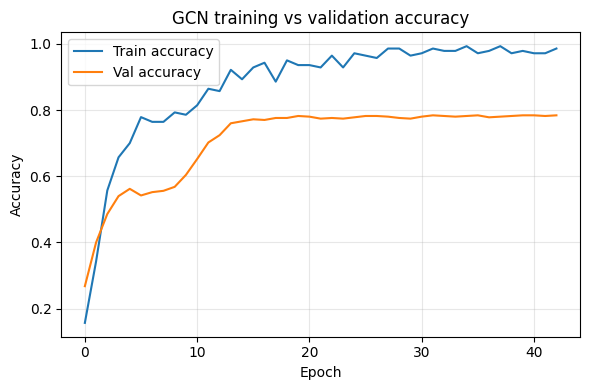

In [4]:
# 5. Train the model with early stopping
from datetime import datetime
batch_size = 256
epochs = 100
patience = 10
DATASET_NAME = "cora"
MODEL_NAME = "gcn"
PLOTS_DIR = os.path.join("..", "results", "plots", MODEL_NAME)
os.makedirs(PLOTS_DIR, exist_ok=True)
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M")


optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss_fn = keras.losses.CategoricalCrossentropy(reduction="none")

history_acc = []
history_val_acc = []
best_val_loss = float("inf")
wait = 0
best_weights = None

train_mask_tf = tf.convert_to_tensor(train_mask)
val_mask_tf = tf.convert_to_tensor(val_mask)
mask_train_norm = tf.reduce_sum(train_mask_tf)
mask_val_norm = tf.reduce_sum(val_mask_tf)

for epoch in range(1, epochs + 1):
    with tf.GradientTape() as tape:
        logits = model([X, A_tensor], training=True)
        loss_raw = loss_fn(y, logits)
        loss = tf.reduce_sum(loss_raw * train_mask_tf) / mask_train_norm
        total_loss = loss + tf.add_n(model.losses)
    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Train metrics
    train_pred = tf.argmax(logits, axis=1)
    train_true = tf.argmax(y, axis=1)
    train_acc = tf.reduce_mean(tf.cast(tf.equal(train_pred, train_true), tf.float32) * train_mask_tf) / (mask_train_norm / tf.cast(tf.shape(train_true)[0], tf.float32))

    # Val metrics
    val_logits = model([X, A_tensor], training=False)
    val_loss_raw = loss_fn(y, val_logits)
    val_loss = tf.reduce_sum(val_loss_raw * val_mask_tf) / mask_val_norm
    val_pred = tf.argmax(val_logits, axis=1)
    val_true = tf.argmax(y, axis=1)
    val_acc = tf.reduce_mean(tf.cast(tf.equal(val_pred, val_true), tf.float32) * val_mask_tf) / (mask_val_norm / tf.cast(tf.shape(val_true)[0], tf.float32))

    history_acc.append(float(train_acc))
    history_val_acc.append(float(val_acc))

    print(f"Epoch {epoch:03d} | loss {float(loss):.4f} | val_loss {float(val_loss):.4f} | train_acc {float(train_acc):.4f} | val_acc {float(val_acc):.4f}")

    if val_loss < best_val_loss:
        best_val_loss = float(val_loss)
        wait = 0
        best_weights = model.get_weights()
    else:
        wait += 1
        if wait > patience:
            print("Early stopping")
            break

if best_weights is not None:
    model.set_weights(best_weights)

# Training/validation accuracy plot
plt.figure(figsize=(6, 4))
plt.plot(history_acc, label="Train accuracy")
plt.plot(history_val_acc, label="Val accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("GCN training vs validation accuracy")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
filename = (
    f"{DATASET_NAME}_{MODEL_NAME}"
    f"_lr{learning_rate}_dp{dropout_rate}"
    f"_{timestamp}.png"
)

plt.savefig(
    os.path.join(PLOTS_DIR, filename),
    dpi=300,
    bbox_inches="tight"
)
plt.show()
plt.close()


## 6. Evaluate on train/val/test 

In [5]:
# Predictions for all nodes (no batching)
logits = model([X, A_tensor], training=False)
labels_true = tf.argmax(y, axis=1).numpy()
labels_pred = tf.argmax(logits, axis=1).numpy()

results = {}
for split_name, mask in {
    "train": train_mask,
    "val": val_mask,
    "test": test_mask,
}.items():
    mask_np = mask.numpy().astype(bool)
    true_split = labels_true[mask_np]
    pred_split = labels_pred[mask_np]
    acc = accuracy_score(true_split, pred_split)
    prec, rec, f1, _ = precision_recall_fscore_support(
        true_split, pred_split, average="macro", zero_division=0
    )
    results[split_name] = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
    }
    print(f"{split_name.title()} metrics:")
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall:    {rec:.4f}")
    print(f"  F1:        {f1:.4f}\n")

# Safety check: ensure test accuracy is reasonable (>0.80 expected)
if results["test"]["accuracy"] < 0.80:
    raise ValueError("Test accuracy < 0.80; please debug before proceeding.")


Train metrics:
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1:        1.0000

Val metrics:
  Accuracy:  0.7840
  Precision: 0.7602
  Recall:    0.7958
  F1:        0.7718

Test metrics:
  Accuracy:  0.8130
  Precision: 0.7947
  Recall:    0.8235
  F1:        0.8053



## 7. Save test metrics to `results/metrics.csv`

In [6]:
# 7.1 Save metrics to results/metrics.csv

import csv
import os

RESULTS_DIR = "../results"
os.makedirs(RESULTS_DIR, exist_ok=True)

metrics_path = os.path.join(RESULTS_DIR, "metrics.csv")
file_exists = os.path.isfile(metrics_path)

fieldnames = [
    "model",
    "dataset",
    "test_accuracy",
    "test_precision_macro",
    "test_recall_macro",
    "test_f1_macro",
]

row = {
    "model": "GCN",
    "dataset": "cora",
    "test_accuracy": f"{acc:.4f}",
    "test_precision_macro": f"{prec:.4f}",
    "test_recall_macro": f"{rec:.4f}",
    "test_f1_macro": f"{f1:.4f}",
}

with open(metrics_path, mode="a", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    if not file_exists:
        writer.writeheader()
    writer.writerow(row)

print(f"✅ Saved GCN metrics to {metrics_path}")


✅ Saved GCN metrics to ../results/metrics.csv
